# **Machine Learning from Data**

## Lab 1: MAP and Gaussian data - Part 1



2021-2023 - Veronica Vilaplana - [GPI @ IDEAI](https://imatge.upc.edu/web/) Research group

-----------------

##Classification criteria based on maximizing the posterior probability

##Part1: Linear and quadratic discriminant classifiers on Gaussian data
In this first part we will work on a classification problem using synthetic data corresponding to **two classes and three features per class**. Features are statistically independent and will be characterized by their covariance matrices following Case1 studied in class: same covariance matrix following this expression:
$C= \sigma^2 I$

In [2]:
import pandas as pd             #import pandas with the alias pd
import numpy as np              #import numpy with the alias np
import seaborn as sns           #import seaborn with the alias sns
import scipy.stats as ss
import scipy as sp
import matplotlib.pyplot as plt #import matplotlib.pyplot with the alias plt

#1. Data generation

###Parameter initialization

The parameter $\sigma$ will be derived from the desired SNR, given as input:

In [3]:
# Input a SNR value (3, 0, -3, 10):
SNR = 3

In [4]:
dist=1.       #distance between means
n_classes = 2
n_samples = 1000;
n_feat = 3
# M_Means matrix containing the two mean vectors
M_Means = 0.5 * dist * np.array([[1, 1, 1],[-1,-1,-1]]) / np.sqrt(n_feat)

In [5]:
# Energy computation
energy = 0
for i in range(0,n_classes):
  energy = energy + np.dot(M_Means[i],M_Means[i])
energy = energy / n_classes

In [6]:
# Noise variance computation
SNR = 10 ** (SNR/10)
sig = energy / SNR
sig = sig / n_feat

In [7]:
# Covariance matrix
M_covar = np.zeros(shape=(2,3,3))
sigma = sig * np.array([1,1])
for i in range(0,n_classes):
  M_covar[i,:,:] = sigma[i] * np.eye(N=n_feat,M=n_feat)

In [8]:
print(sigma)
print(M_covar)

[0.0417656 0.0417656]
[[[0.0417656 0.        0.       ]
  [0.        0.0417656 0.       ]
  [0.        0.        0.0417656]]

 [[0.0417656 0.        0.       ]
  [0.        0.0417656 0.       ]
  [0.        0.        0.0417656]]]


###Dataset generation

Random Generation: The Numpy class Generator exposes a number of methods for generating random numbers drawn from a variety of probability distributions.

`random.default_rng` is the recommended constructor for the random number class Generator. The parameter `seed` specifies a seed so that we have reproducible results.

`random.Generator.multivariate_normal` draws random samples from a multivariate normal distribution.

In [9]:
from numpy.random import default_rng
# initialize with a seed such that every execution will raise same random sequences of results
rng = default_rng(seed=5)

In [10]:
# Dataset Generation
# labels is a 1D array with 0-1 int labels
# xdata is a 2D array (columns = features, rows= samples) with random numbers
xdata = np.empty((0,n_feat), float)
labels = np.empty((0), int)
for i in range(0,n_classes):
  ydata = rng.multivariate_normal(mean=M_Means[i,:], cov= M_covar[i,:,:], size= n_samples)
  ylabels = i * np.ones((n_samples),dtype=int)
  xdata = np.append(xdata, ydata, axis=0)
  labels = np.append(labels, ylabels, axis=0)

###Histograms

We plot histograms per feature and class

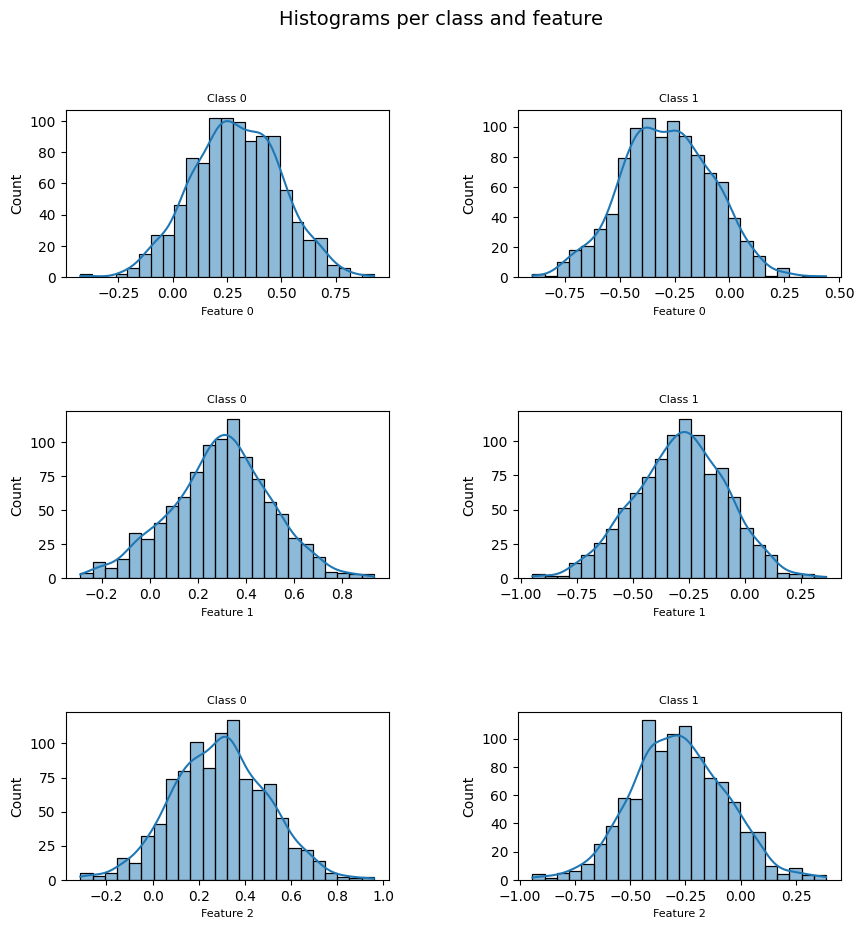

In [11]:
# itererate over the classes and features
# extract the data and plot a separated plot with the histogram
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(10,10), nrows= 3, ncols=2)
fig.suptitle('Histograms per class and feature', fontsize=14)
fig.subplots_adjust(hspace=0.8, wspace=0.4)
for idfeat in range(0, n_feat):
  for idclass in range(0, n_classes):
    #extract data
    index = labels== idclass
    xd = xdata[index,idfeat]
    iax = 2 * idfeat + idclass + 1

    plt.subplot(3,2,iax)
    # sns.distplot(xd, fit=norm, kde=False)
    sns.histplot(xd,  kde=True)

    plt.title('Class %d' %idclass, fontsize=8)
    plt.xlabel('Feature %d' %idfeat, fontsize=8)
    plt.axis('auto')

plt.show()

###Scatter plots

Then, we shuffle the data, create a dataframe and plot 2D and 3D scatter plots.

In [12]:
# shuffle data (xdata and labels, same order)
rp = np.random.permutation(len(xdata))
xdatas = xdata[rp]
xlabs  = labels[rp]

# create dataframe
xd = pd.DataFrame(xdatas,columns=['feat1','feat2','feat3'])
xl = pd.DataFrame(xlabs,columns=['class'])
xdl = xd.join(xl)
#check dataframe
xdl.head()


,feat1,feat2,feat3,class
0,0.188003,0.160180,0.058605,0
1,0.032397,0.588460,0.437578,0
2,-0.255856,-0.346748,-0.026956,1
3,0.242869,0.379928,0.141241,0
4,-0.022325,0.108333,-0.416752,1


####*2D Scatter Plot*

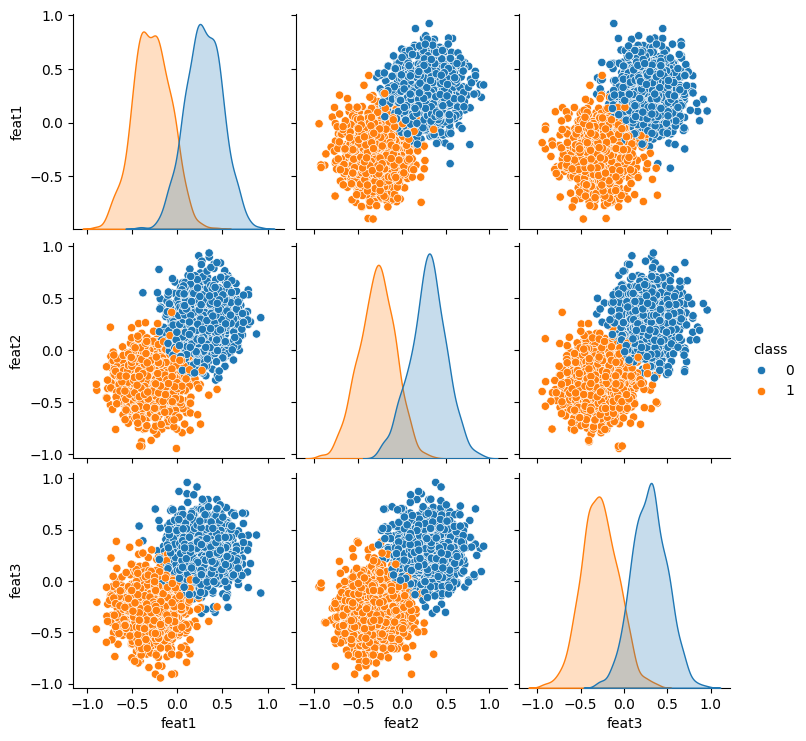

In [13]:
# scatter plot shuffled data
sns.pairplot(xdl,hue='class');
plt.draw()

####*3D Scatter Plot*

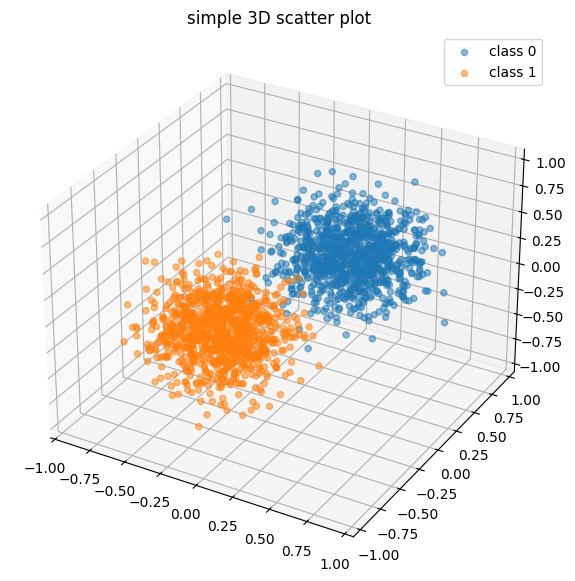

In [14]:
# 3D scatter plot
fig = plt.figure(figsize = (10,7))
ax = plt.axes(projection ="3d")
col = ['tab:blue','tab:orange']
for idclass in range(0, n_classes):
  # Creating plot class 0
  idx = xlabs==idclass
  ax.scatter3D(xdatas[idx,0], xdatas[idx,1], xdatas[idx,2], color = col[idclass], label='class %d' %idclass,alpha=0.5);

plt.title("simple 3D scatter plot")
plt.legend()
plt.show()


#2. Introduction to Scikit-Learn

[Scikit-learn](https://scikit-learn.org/stable/) is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities.

Scikit-Learn is characterized by a clean, uniform API, and a very useful and complete online documentation. A benefit of this uniformity is that once you understand the basic use and syntax of Scikit-Learn for one type of model, switching to a new model or algorithm is  straightforward.

We will see how to represent data in Scikit-learn and then a brief introduction to the Estimator API.

##Data representation
The best way to think about data within Scikit-Learn is in terms of tables of data. A basic table is a two-dimensional grid, in which the rows represent individual elements or *samples* of the dataset, and the columns represent *features* or quantities related to each of these elements.

###The Features matrix
The information is therefore organized in a two-dimensional numerical array or matrix, the *features matrix*. It is assumed to be two-dimensional, with shape `[n_samples, n_features]`, and is usually contained in a NumPy array or a Pandas `DataFrame`.

The rows correspond to individual objects or samples described by the datset, and the columns refer to features, distinct observations that describe each sample quantitatively (real values, boolean or discrete values).

### The target array
We also generally work with a *label* or *target* array, which is usually one-dimensional, with length `n_samples`, and it is typically contained in a NumPy array or a Pandas `Series`, with continuous numerical values or discrete clases or labels.
In the labs we will primarily work with one-dimensional target arrays. The target array contains the quantity we want to predict from the data: in statistical terms, it is the dependent variable.

##Estimator API
The Estimator API is one of the main APIs implemented by Scikit-learn. It provides a consistent interface for a wide range of ML applications that’s why all machine learning algorithms in Scikit-Learn are implemented via Estimator API. The object that learns from the data (fitting the data) is an estimator. It can be used with any of the algorithms like classification, regression, clustering or even with a transformer, that extracts useful features from raw data.

Typically, the steps for using the Scikit-Learn estimator API are the following:

1. Choose a class of model by importing the appropriate estimator class from Scikit-Learn.
2. Choose model hyperparameters by instantiating this class with desired values.
3. Arrange data into a features matrix and target vector following the discussion above.
4. Fit the model to the data by calling the ``fit()`` method of the model instance.
5. Apply the Model to new data:
   - For supervised learning, often we predict labels for unknown data using the ``predict()`` method.
   - For unsupervised learning, we often transform or infer properties of the data using the ``transform()`` or ``predict()`` method.


#3. Linear and Quadratic Discriminant Analysis
(from https://scikit-learn.org/stable/modules/lda_qda.html)

Linear Discriminant Analysis (LinearDiscriminantAnalysis) and Quadratic Discriminant Analysis (QuadraticDiscriminantAnalysis) are two classic classifiers, with, as their names suggest, a linear and a quadratic decision surface, respectively.

These classifiers are attractive because they have closed-form solutions that can be easily computed, are inherently multiclass, have proven to work well in practice, and have no hyperparameters to tune.

Both LDA and QDA can be derived from simple probabilistic models which model the class conditional distribution of the data $P(X | y=k)$ for each class k. Predictions can then be obtained by using Bayes’ rule, for each training sample $x \in \mathcal{R}^d$

$$P(y=k | x) = \frac{P(x | y=k) P(y=k)}{P(x)} = \frac{P(x | y=k) P(y = k)}{ \sum_{l} P(x | y=l) \cdot P(y=l)}$$


where $$P(x | y=k) = \frac{1}{(2\pi)^{d/2} |\Sigma_k|^{1/2}}\exp\left(-\frac{1}{2} (x-\mu_k)^t \Sigma_k^{-1} (x-\mu_k)\right)$$

and we select the class $k$  which maximizes this posterior probability.


### QDA
According to the model above, the log of the posterior is:
\begin{split}\log P(y=k | x) &= \log P(x | y=k) + \log P(y = k) + Cst \\
&= -\frac{1}{2} \log |\Sigma_k| -\frac{1}{2} (x-\mu_k)^t \Sigma_k^{-1} (x-\mu_k) + \log P(y = k) + Cst,\end{split}

where the constant term $Cst$ corresponds to the denominator $P(x)$, in addition to other constant terms from the Gaussian. The predicted class is the one that maximises this log-posterior.

### LDA

LDA is a special case of QDA, where the Gaussians for each class are assumed to share the same covariance matrix $\Sigma_k = \Sigma$ for all $k$ . This reduces the log posterior to:
$$ \log P(y=k | x) = -\frac{1}{2} (x-\mu_k)^t \Sigma^{-1} (x-\mu_k) + \log P(y = k) + Cst.$$

The term $(x-\mu_k)^t \Sigma^{-1} (x-\mu_k)$ corresponds to the Mahalanobis Distance between the sample $x$ and the mean $\mu_k$.

The Mahalanobis distance tells how close $x$ is from $\mu_k$, while also accounting for the variance of each feature. We can thus interpret LDA as assigning $x$ to the class whose mean is the closest in terms of Mahalanobis distance, while also accounting for the class prior probabilities.



###Fit and evaluate a linear and a quadratic classifier
1. First we will train the classifiers (using the `fit` method)
2. Then, we make the predictions (`predict`) and compute error, confusion matrices and the ROC curve on the training data

The `sklearn.metrics` module implements functions assessing prediction error for specific purposes.

In [15]:
# Create a linear discriminant analysis classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay


X_train = xdatas
y_train = xlabs

# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(solver="svd",store_covariance=True)
ldamodel = lda.fit(X_train, y_train)
y_tpred_lda = ldamodel.predict(X_train)

print('LDA model priors:',ldamodel.priors_)
print('LDA model means:',ldamodel.priors_)
print('LDA models covariance:', ldamodel.covariance_)


linear_error = 1. - accuracy_score(y_train,y_tpred_lda)
print('LDA error: %f' %linear_error)
print('LDA confusion matrix:')
print(confusion_matrix(y_train,y_tpred_lda))


# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qdamodel = qda.fit(X_train, y_train)
y_tpred_qda = qdamodel.predict(X_train)

print('QDA model priors:',qdamodel.priors_)
print('QDA model means:',qdamodel.priors_)
print('QDA models covariances:', qdamodel.covariance_)

qda_error = 1. - accuracy_score(y_train,y_tpred_qda)
print('QDA error: %f' %qda_error)
print('QDA confusion matrix:')
print(confusion_matrix(y_train,y_tpred_qda))



LDA model priors: [0.5 0.5]
LDA model means: [0.5 0.5]
LDA models covariance: [[ 0.04104051  0.00074874 -0.00176448]
 [ 0.00074874  0.04296684  0.00110801]
 [-0.00176448  0.00110801  0.04242311]]
LDA error: 0.008500
LDA confusion matrix:
[[990  10]
 [  7 993]]
QDA model priors: [0.5 0.5]
QDA model means: [0.5 0.5]
QDA models covariances: [array([[ 0.0405823 ,  0.00269199, -0.00195195],
       [ 0.00269199,  0.04336698,  0.00088929],
       [-0.00195195,  0.00088929,  0.04063567]]), array([[ 0.04158088, -0.00119302, -0.00158053],
       [-0.00119302,  0.04265272,  0.00132894],
       [-0.00158053,  0.00132894,  0.04429548]])]
QDA error: 0.008500
QDA confusion matrix:
[[990  10]
 [  7 993]]


### Plot the ROC curves (on the training set)

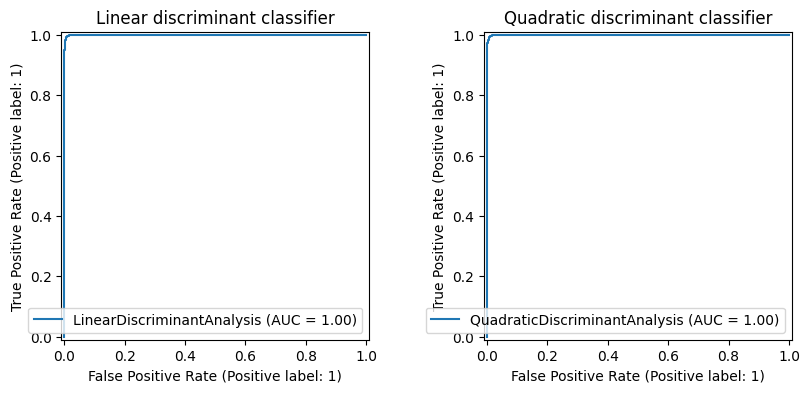

In [16]:
fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
ldaroc = RocCurveDisplay.from_estimator(ldamodel,X_train,y_train, ax=ax[0])
ax[0].set_title('Linear discriminant classifier')
qdaroc = RocCurveDisplay.from_estimator(qdamodel,X_train,y_train, ax=ax[1])
ax[1].set_title('Quadratic discriminant classifier')
plt.show()

###Mahalanobis distance (on the training set)

In [17]:
def mahalanobis(x=None, data=None, cov=None):
  x_minus_mu = x - np.mean(data)
  if not cov:
    cov = np.cov(data.T)
  inv_covmat = sp.linalg.inv(cov)
  left_term = np.dot(x_minus_mu, inv_covmat)
  mahal = np.dot(left_term, x_minus_mu.T)
  return mahal.diagonal()

xdata0 = X_train[y_train==0]
xdata1 = X_train[y_train==1]

md01 = mahalanobis(x = xdata0, data = xdata1)
mdist01 = np.mean(md01)
print(mdist01)

md10 = mahalanobis(x = xdata1, data = xdata0)
mdist10 = np.mean(md10)
print(mdist10)


26.886829216197853
26.72582894831203


## Performance on a fresh test set

An unbiased evaluation of a model fit on the traing data can be obtained by evaluating the model on an independent test set. In this exercise, since the model is trained on randomly generated samples, we do not expect big differences in performance if we test the model on a test set obtained following the same procedure used for creating the training set. Let's check this.

1. We create a test set with 1000 samples per class, with the same distribution as the training data.
2. And test the linear and quadratic classifiers (trained with the training data), compute confusion matrices, error and ROC curves

###Test Set Generation

In [18]:
# Test Set Generation
# labels is a 1D array with 0-1 int labels
# xdata is a 2D array (columns = features, rows= samples) with random numbers
X_test = np.empty((0,n_feat), float)
y_test = np.empty((0), int)
for i in range(0,n_classes):
  ydata = rng.multivariate_normal(mean=M_Means[i,:], cov= M_covar[i,:,:], size= n_samples)
  ylabels = i * np.ones((n_samples),dtype=int)
  X_test = np.append(X_test, ydata, axis=0)
  y_test = np.append(y_test, ylabels, axis=0)

# shuffle data
rp = np.random.permutation(len(X_test))
X_test = X_test[rp]
y_test  = y_test[rp]

###Test Set Performance and ROC curves


In [19]:
# Test classifiers, compute confusion matrices, error and plot ROC curves

# LDA
y_test_lda = ldamodel.predict(X_test)
linear_error = 1. - accuracy_score(y_test,y_test_lda)
print('LDA error: %f' %linear_error)
print('LDA confusion matrix:')
print(confusion_matrix(y_test,y_test_lda))

# QDA
y_test_qda = qdamodel.predict(X_test)
qda_error = 1. - accuracy_score(y_test,y_test_qda)
print('QDA error: %f' %qda_error)
print('QDA confusion matrix:')
print(confusion_matrix(y_test,y_test_qda))

LDA error: 0.009500
LDA confusion matrix:
[[992   8]
 [ 11 989]]
QDA error: 0.010000
QDA confusion matrix:
[[992   8]
 [ 12 988]]


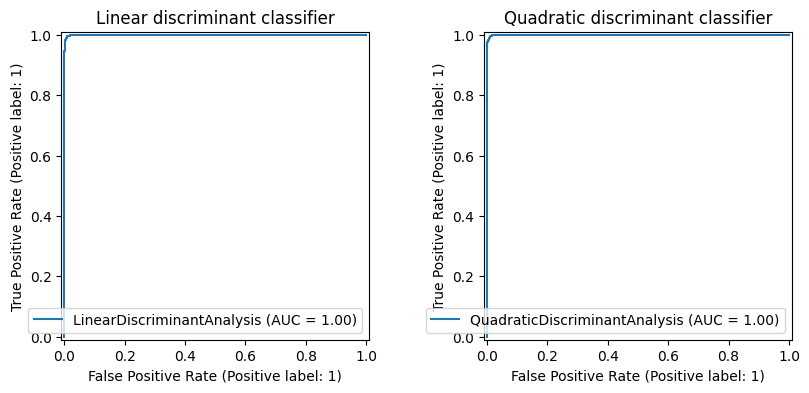

In [20]:
# ROC curves
fig, ax = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
ldaroc = RocCurveDisplay.from_estimator(ldamodel,X_test,y_test, ax=ax[0])
ax[0].set_title('Linear discriminant classifier')
qdaroc = RocCurveDisplay.from_estimator(qdamodel,X_test,y_test, ax=ax[1])
ax[1].set_title('Quadratic discriminant classifier')
plt.show()

###Mahalanobis distance on test set

In [21]:
xdata0 = X_test[y_test==0]
xdata1 = X_test[y_test==1]

md01 = mahalanobis(x = xdata0, data = xdata1)
mdist01 = np.mean(md01)
print(mdist01)

md10 = mahalanobis(x = xdata1, data = xdata0)
mdist10 = np.mean(md10)
print(mdist10)


26.46271472962467
26.825706588222626
